<a href="https://www.kaggle.com/code/bikaskumarbehera/braincancerclassification?scriptVersionId=136739075" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data Preparation

In [1]:
%%time

import numpy as np

images = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}")
print(f"masks:{masks.shape}")
print(f"labels:{labels.shape}")

images:(3064,)
masks:(3064,)
labels:(3064,)
CPU times: user 1.01 s, sys: 2.09 s, total: 3.09 s
Wall time: 15 s


Stacking rows as a data frame.

In [2]:
data = np.column_stack((images, masks, labels))
data.shape

(3064, 3)

Split data on train val test

In [3]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.08, random_state=42)
train_data, test_data = train_test_split(train_data, test_size=0.12, random_state=42)

print("Train:", train_data.shape,
      "\nVal:", val_data.shape, 
      "\nTest:", test_data.shape,)

Train: (2479, 3) 
Val: (246, 3) 
Test: (339, 3)


# visualization of data

Class distribution

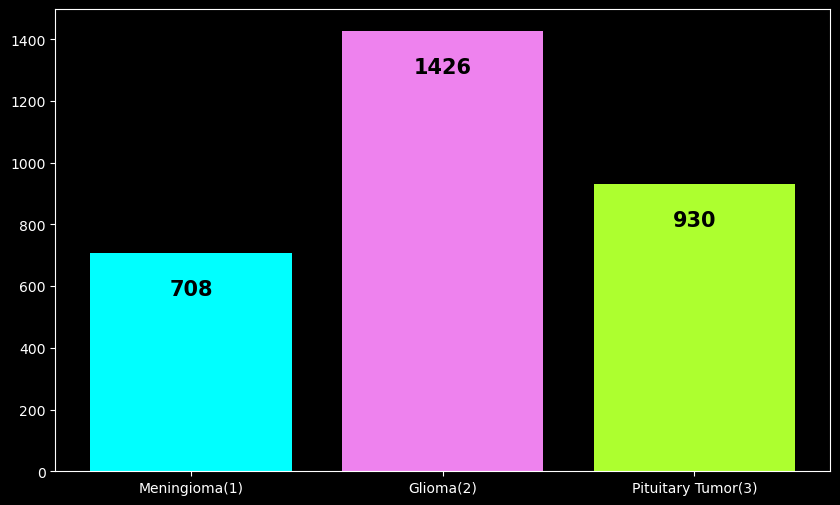

In [4]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

labels, counts = np.unique(data[:,2], return_counts=True)

plt.figure(figsize=(10,6))
plt.bar(labels, counts, color=["aqua", "violet", "greenyellow"],
        tick_label=['Meningioma(1)', 'Glioma(2)', 'Pituitary Tumor(3)'])

# Annotate
for row, value in zip(labels,counts):
    plt.annotate(int(value), xy=(row, value-150), 
                rotation=0, color="black", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")

Samples of images of each class

In [5]:
import cv2

def data_to_viz(data, label, n=5):
    
    # logical slice for receiving data with the expected label
    expected_index = np.where(data[:,2] == label)
    expected_data = data[expected_index]
    
    # n random samples
    index = np.random.choice(expected_data.shape[0], n, replace=False)
    data_to_viz = expected_data[index]
    
    imgs = []
    masks = []
    labels = []
    for data_i in data_to_viz:
        
        # img
        imgs.append(cv2.resize(data_i[0], (512, 512)))

        # mask
        masks.append(cv2.resize(data_i[1].astype("uint8"), 
                                (512, 512)))

        # label
        labels.append(data_i[2])

    return np.hstack(imgs), np.hstack(masks), labels

Detailed Data

In [6]:
meningiomas_imgs, meningiomas_masks, meningiomas_labels = data_to_viz(data, label=1, n=5)
glioma_imgs, glioma_masks, glioma_labels  = data_to_viz(data, label=2, n=5)
tumor_imgs, tumor_masks, tumor_labels = data_to_viz(data, label=3, n=5)

print("Meningiomas:",
      meningiomas_imgs.shape, meningiomas_masks.shape, meningiomas_labels)
print("Glioma:",
      glioma_imgs.shape, glioma_masks.shape, glioma_labels)
print("Pituitary Tumor:",
      tumor_imgs.shape, tumor_masks.shape, tumor_labels)

Meningiomas: (512, 2560) (512, 2560) [1, 1, 1, 1, 1]
Glioma: (512, 2560) (512, 2560) [2, 2, 2, 2, 2]
Pituitary Tumor: (512, 2560) (512, 2560) [3, 3, 3, 3, 3]


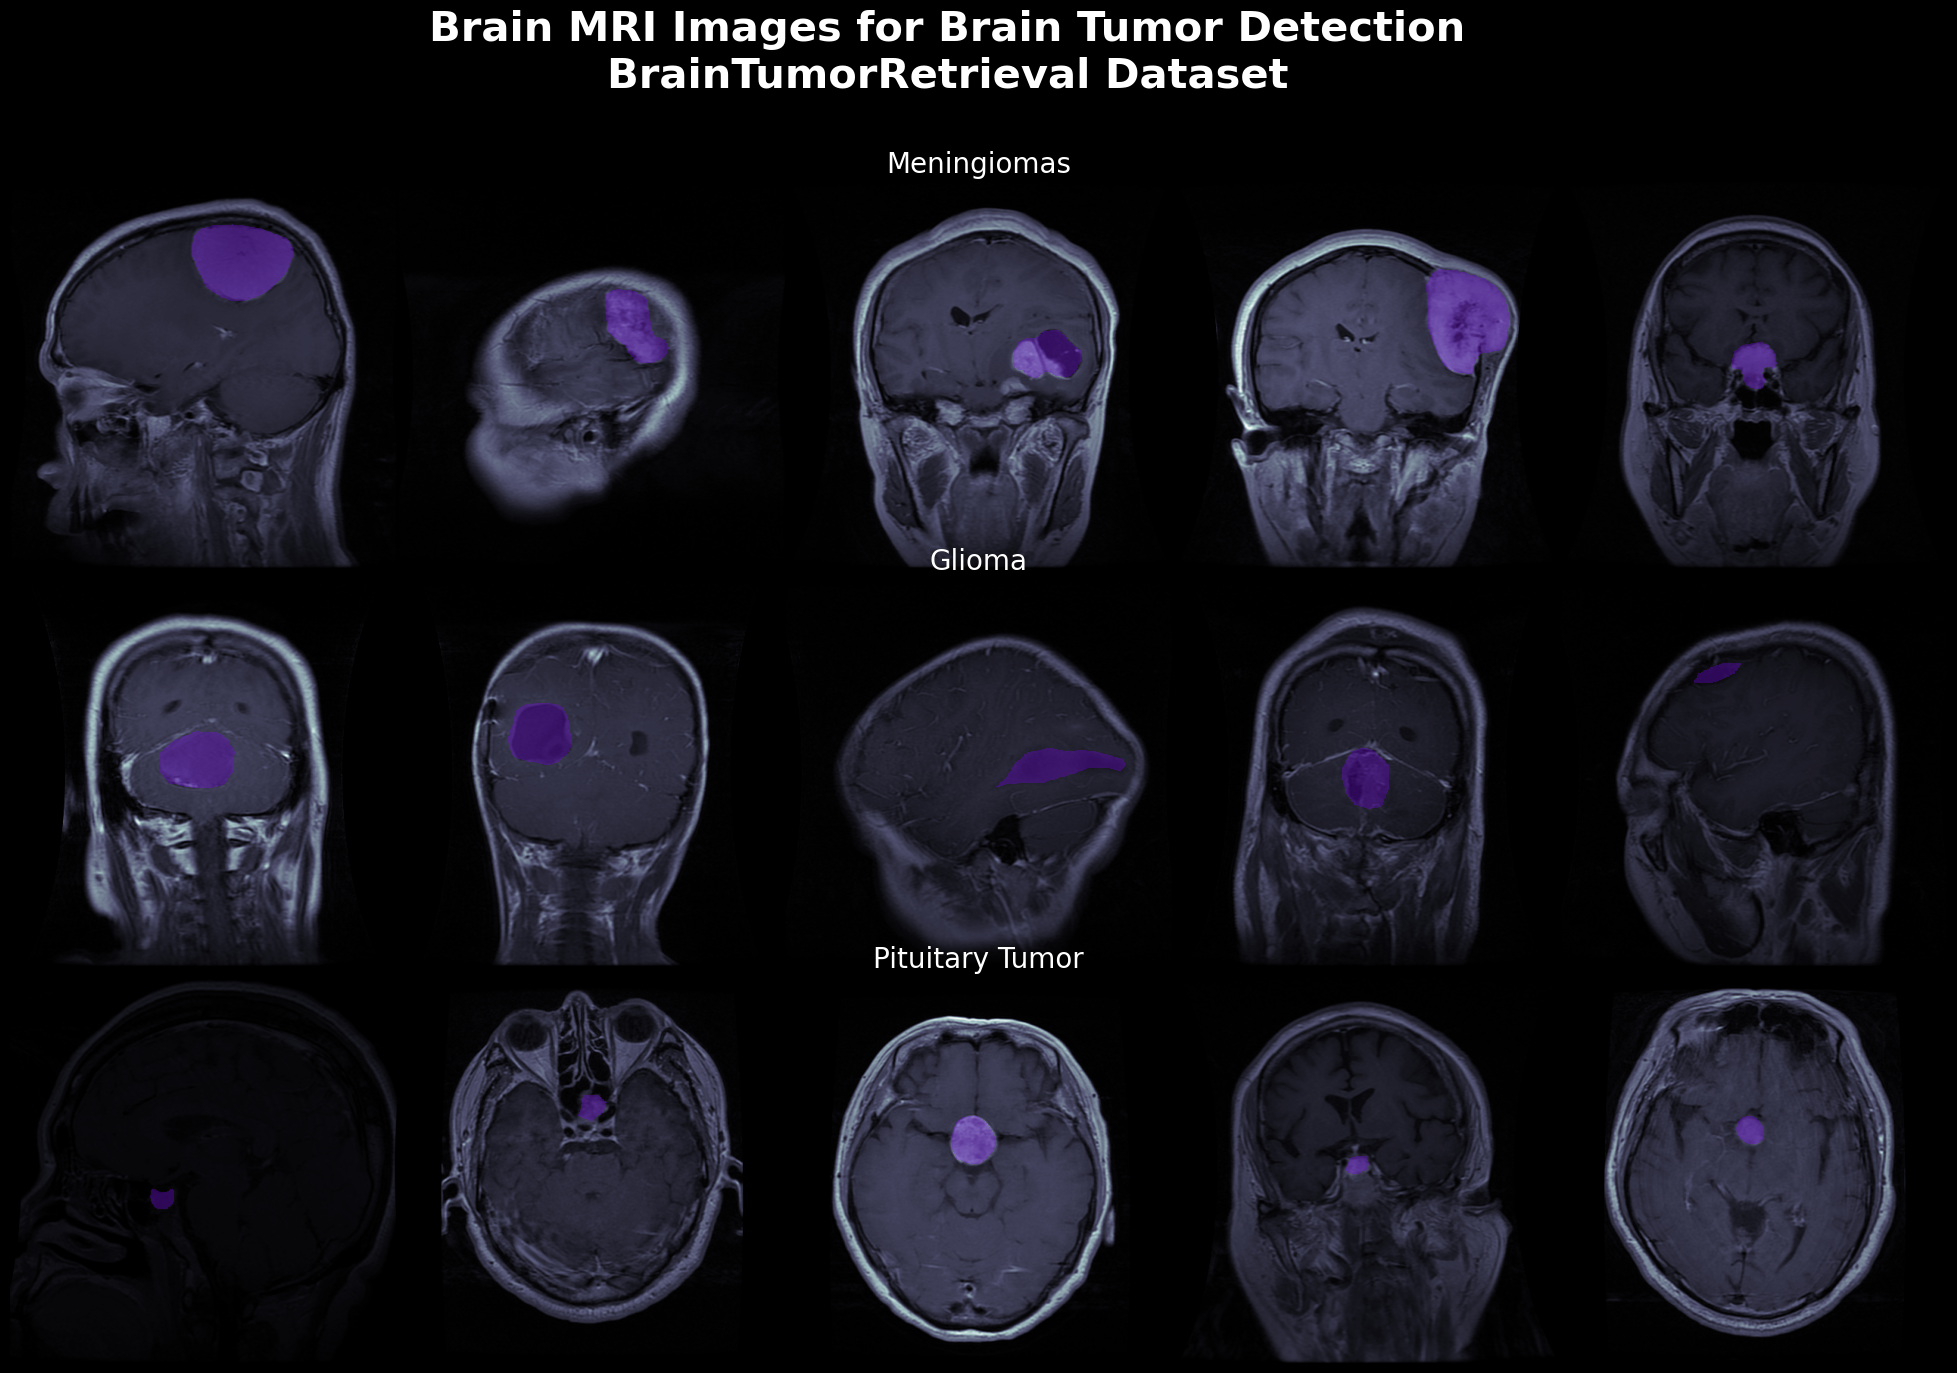

In [7]:
# Data to visualization
from mpl_toolkits.axes_grid1 import ImageGrid

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 1),  # creates 1x4 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(meningiomas_imgs, cmap="bone")
grid[0].imshow(np.ma.masked_where(meningiomas_masks == False, 
                                  meningiomas_masks), cmap='rainbow', alpha=0.3)

grid[0].set_title("Meningiomas", fontsize=20)
grid[0].axis("off")

grid[1].imshow(glioma_imgs, cmap="bone")
grid[1].imshow(np.ma.masked_where(glioma_masks == False,
                                  glioma_masks), cmap='rainbow', alpha=0.3)
grid[1].set_title("Glioma", fontsize=20)
grid[1].axis("off")

grid[2].imshow(tumor_imgs, cmap="bone")
grid[2].imshow(np.ma.masked_where(tumor_masks == False,
                                  tumor_masks), cmap='rainbow', alpha=0.3)

grid[2].set_title("Pituitary Tumor", fontsize=20)
grid[2].axis("off")


# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nBrainTumorRetrieval Dataset",
             y=.80, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", pad_inches=0.2, transparent=True)
plt.show()

# Data Preprocessing

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
#from albumentations.pytorch import ToTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
from matplotlib.colors import Normalize
class BrainMriDataset(Dataset):
    def __init__(self, data, transforms, n_classes=3):
        self.data = data
        self.transforms = transforms
        self.n_classes = n_classes
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx][0].astype("float32")
        
        norm = Normalize(vmin= image.min(), vmax = image.max())
        image = norm(image)
        
        # median filtering
        image = cv2.medianBlur(image, 3)
        
        # convert to rgb
        image_rgb = np.stack([image]*3).transpose(1,2,0)
        
        # create target label
        label = self.data[idx][2]
        
        # augmentations
        augmented = self.transforms(image=image_rgb)
        image = augmented['image']
        
        return image, label

Data Transformation

In [10]:
# Define a sequence of image augmentation techniques
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(
        max_holes=8, 
        max_height=8, 
        max_width=8, 
        min_holes=2,
        min_height=2, 
        min_width=2, 
        fill_value=0, 
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2, 
        contrast_limit=0.1, 
        p=0.3
    )
])


# Data Splitting

Create Directories

In [13]:
import os

# Define the directory paths
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

# Create the directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create subdirectories for each label in the train, validation, and test directories
for i in range(1, 4):
    os.makedirs(os.path.join(train_dir, str(i)))
    os.makedirs(os.path.join(val_dir, str(i)))
    os.makedirs(os.path.join(test_dir, str(i)))


For Deleting Directories

In [12]:
import shutil

# directory paths
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/validation"
test_dir = "/kaggle/working/test"

# remove directories
shutil.rmtree(train_dir)
shutil.rmtree(val_dir)
shutil.rmtree(test_dir)

Split the Data into 3 parts train_dataset, val_dataset, test_dataset and save it in respective directories

In [14]:
# train
j  = 1
train_dataset=None
train_dataset = BrainMriDataset(data=train_data, transforms=transforms)

for item in train_dataset:
    img, label = item
    plt.imsave('/kaggle/working/train/{}/{}.jpg'.format(label, j), img)
    j+=1
print('Write Completed')

Write Completed


In [15]:
# validation
j  = 1
val_dataset=None
val_dataset = BrainMriDataset(data=val_data, transforms=transforms)

for item in val_dataset:
    img, label = item
    plt.imsave('/kaggle/working/validation/{}/{}.jpg'.format(label, j), img)
    j+=1
print('Write Completed')

Write Completed


In [16]:
# test
j  = 1
test_dataset=None
test_dataset = BrainMriDataset(data=test_data, transforms=transforms)

for item in test_dataset:
    img, label = item
    plt.imsave('/kaggle/working/test/{}/{}.jpg'.format(label, j), img)
    j+=1
print('Write Completed')

Write Completed


# Data visualization

In [17]:
print("Train")
Total = 0
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/train/3'):
    for filename in filenames:
        count+=1
print("Pitutary", count)
Total = Total + count
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/train/2'):
    for filename in filenames:
        count+=1
print("Glioma",count)
Total = Total + count
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/train/1'):
    for filename in filenames:
        count+=1
print("Meningioma",count)
Total = Total + count
print("Total", Total)

print("\nValidation")
Total = 0
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/validation/3'):
    for filename in filenames:
        count+=1
print("Pitutary", count)
Total = Total + count
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/validation/2'):
    for filename in filenames:
        count+=1
print("Glioma",count)
Total = Total + count
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/validation/1'):
    for filename in filenames:
        count+=1
print("Meningioma",count)
Total = Total + count
print("Total", Total)

print("\nTest")
Total = 0
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/test/3'):
    for filename in filenames:
        count+=1
print("Pitutary", count)
Total = Total + count
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/test/2'):
    for filename in filenames:
        count+=1
print("Glioma",count)
Total = Total + count
count = 0
for dirname, _, filenames in os.walk('/kaggle/working/test/1'):
    for filename in filenames:
        count+=1
print("Meningioma",count)
Total = Total + count
print("Total", Total)

Train
Pitutary 766
Glioma 1155
Meningioma 558
Total 2479

Validation
Pitutary 71
Glioma 109
Meningioma 66
Total 246

Test
Pitutary 93
Glioma 162
Meningioma 84
Total 339


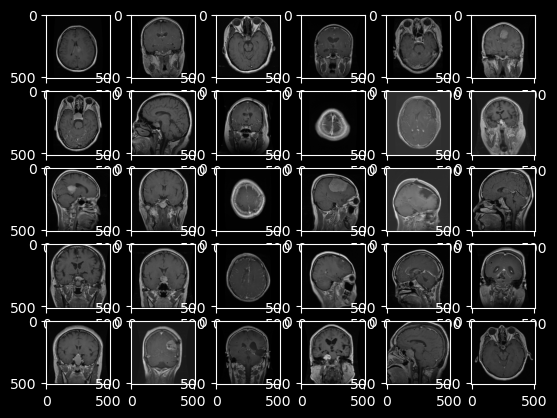

In [18]:
i = 0
for img in train_dataset:
    if i >= 30:
        break
    i += 1
    plt.subplot(5,6,i)
    plt.imshow(img[0])

# **Train Model** (ResNet50)

In [19]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Define data directories and hyperparameters
train_dir = 'train/'
valid_dir = 'validation/'
test_dir = 'test/'
input_shape = (224, 224, 3)
batch_size = 32
num_classes = 3
learning_rate = 0.0001
epochs = 50

# Define data generators
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1
)
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define HDL2BT model
base_model = tf.keras.applications.ResNet50(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last two blocks
for layer in base_model.layers[:-38]:
    layer.trainable = False

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer=Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping and model checkpoint callbacks
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10
)

mc = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=3,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[es, mc],
)

Found 2479 images belonging to 3 classes.
Found 246 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.8006
Epoch 1: val_accuracy improved from -inf to 0.70536, saving model to best_model.h5
77/77 [==============================] - 54s 485ms/step - loss: 0.4768 - accuracy: 0.8006 - val_loss: 1.3308 - val_accuracy: 0.7054
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9342
Epoch 2: val_accuracy improved from 0.70536 to 0.91518, saving model to best_model.h5
77/77 [==============================] - 37s 486ms/step - loss: 0.1893 - accuracy: 0.9342 - val_loss: 0.3350 - val_accuracy: 0.9152
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9501
Epoch 3: val_accuracy did not improve from 0.91518
77/77 [==============================] - 37s 

# **Post Analysis**

11/11 [==============================] - 2s 154ms/step - loss: 0.4047 - accuracy: 0.9351
Test loss: 0.4047
Test accuracy: 0.9351
11/11 [==============================] - 3s 136ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        84
           1       0.98      0.93      0.95       162
           2       0.87      1.00      0.93        93

    accuracy                           0.94       339
   macro avg       0.93      0.94      0.93       339
weighted avg       0.94      0.94      0.94       339



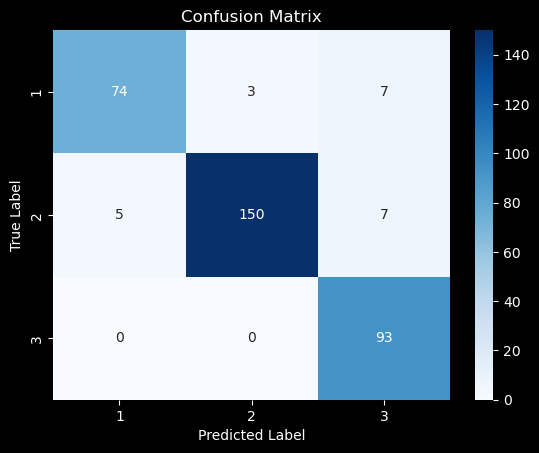

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

# Get predicted classes and true classes for test data
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_generator.classes

# Generate classification report and confusion matrix
print('Classification Report')
print(classification_report(test_true_classes, test_pred_classes))

# Generate confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Define class labels
class_labels = test_generator.class_indices.keys()

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show plot
plt.show()

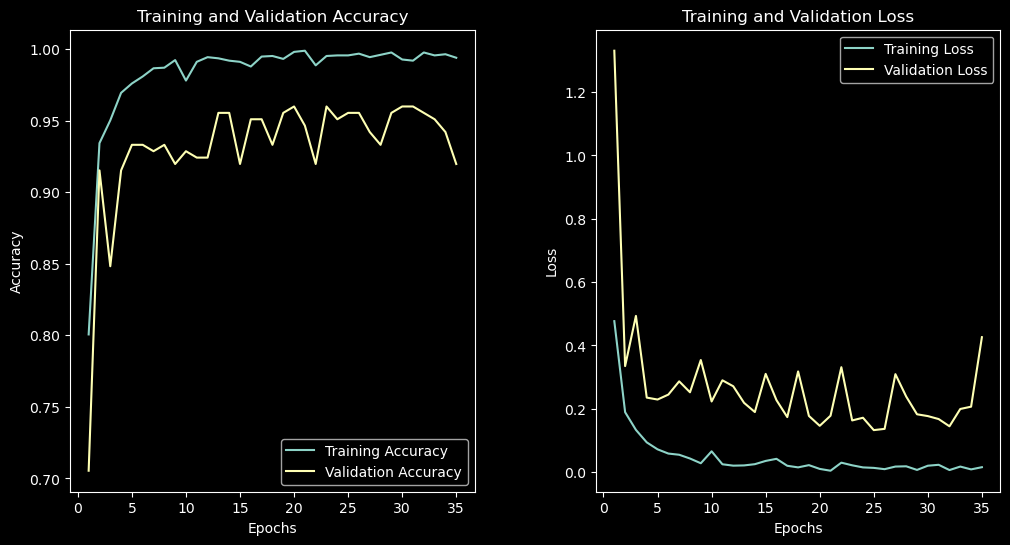

In [21]:
# Get the training accuracy and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the training loss and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Set up the epochs variable
epochs = range(1, len(train_acc) + 1)

# Set up the figure and subplots
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[3, 3])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Plot training and validation accuracy
ax1.plot(epochs, train_acc, label='Training Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and validation loss
ax2.plot(epochs, train_loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Add a gap between the subplots
fig.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

load the saved model

In [22]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('best_model.h5')

# Make predictions using the loaded model
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_generator.classes

11/11 [==============================] - 3s 140ms/step


K-Fold Cross Validation

Fold 1
Found 2479 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Epoch 1/10
78/78 [==============================] - 43s 436ms/step - loss: 0.0033 - accuracy: 0.9996
Epoch 2/10
78/78 [==============================] - 34s 441ms/step - loss: 0.0183 - accuracy: 0.9948
Epoch 3/10
78/78 [==============================] - 34s 436ms/step - loss: 0.0240 - accuracy: 0.9911
Epoch 4/10
78/78 [==============================] - 34s 439ms/step - loss: 0.0165 - accuracy: 0.9968
Epoch 5/10
78/78 [==============================] - 35s 441ms/step - loss: 0.0127 - accuracy: 0.9952
Epoch 6/10
78/78 [==============================] - 35s 443ms/step - loss: 0.0332 - accuracy: 0.9911
Epoch 7/10
78/78 [==============================] - 34s 437ms/step - loss: 0.0187 - accuracy: 0.9944
Epoch 8/10
78/78 [==============================] - 34s 440ms/step - loss: 0.0040 - accuracy: 0.9992
Epoch 9/10
78/78 [==============================] - 34s 441ms/step - loss: 0.0097 - accuracy: 0.9976
E

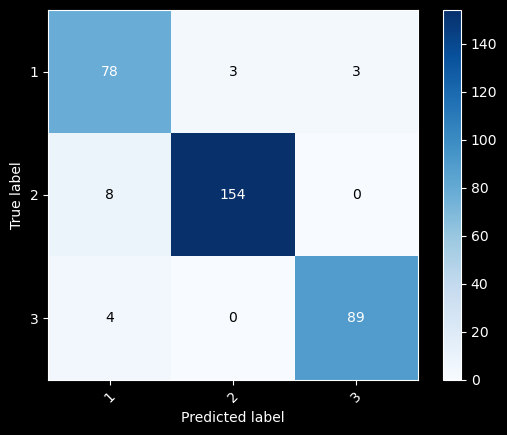

Mean test accuracy: 0.9469 +/- 0.0000
Fold 2
Found 2479 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Epoch 1/10
78/78 [==============================] - 35s 441ms/step - loss: 0.0229 - accuracy: 0.9964
Epoch 2/10
78/78 [==============================] - 34s 436ms/step - loss: 0.0329 - accuracy: 0.9899
Epoch 3/10
78/78 [==============================] - 34s 437ms/step - loss: 0.0159 - accuracy: 0.9952
Epoch 4/10
78/78 [==============================] - 35s 438ms/step - loss: 0.0105 - accuracy: 0.9968
Epoch 5/10
78/78 [==============================] - 35s 443ms/step - loss: 0.0085 - accuracy: 0.9976
Epoch 6/10
78/78 [==============================] - 35s 443ms/step - loss: 0.0083 - accuracy: 0.9988
Epoch 7/10
78/78 [==============================] - 35s 444ms/step - loss: 0.0153 - accuracy: 0.9964
Epoch 8/10
78/78 [==============================] - 35s 445ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 9/10
78/78 [==============================] - 34s 439ms/st

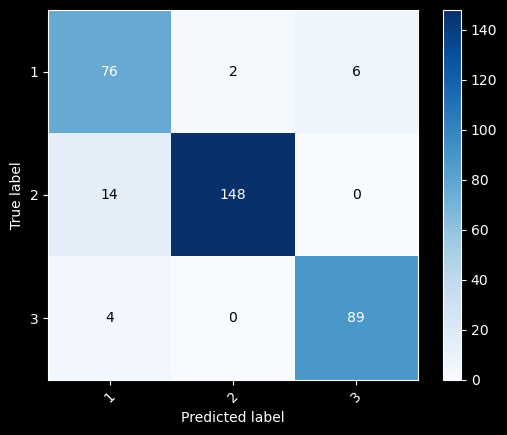

Mean test accuracy: 0.9410 +/- 0.0059
Fold 3
Found 2479 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Epoch 1/10
78/78 [==============================] - 35s 447ms/step - loss: 0.0228 - accuracy: 0.9935
Epoch 2/10
78/78 [==============================] - 34s 440ms/step - loss: 0.0148 - accuracy: 0.9972
Epoch 3/10
78/78 [==============================] - 34s 436ms/step - loss: 0.0025 - accuracy: 0.9992
Epoch 4/10
78/78 [==============================] - 34s 438ms/step - loss: 0.0177 - accuracy: 0.9948
Epoch 5/10
78/78 [==============================] - 34s 437ms/step - loss: 0.0050 - accuracy: 0.9984
Epoch 6/10
78/78 [==============================] - 34s 437ms/step - loss: 0.0202 - accuracy: 0.9948
Epoch 7/10
78/78 [==============================] - 34s 439ms/step - loss: 0.0052 - accuracy: 0.9988
Epoch 8/10
78/78 [==============================] - 34s 435ms/step - loss: 0.0040 - accuracy: 0.9996
Epoch 9/10
78/78 [==============================] - 34s 440ms/st

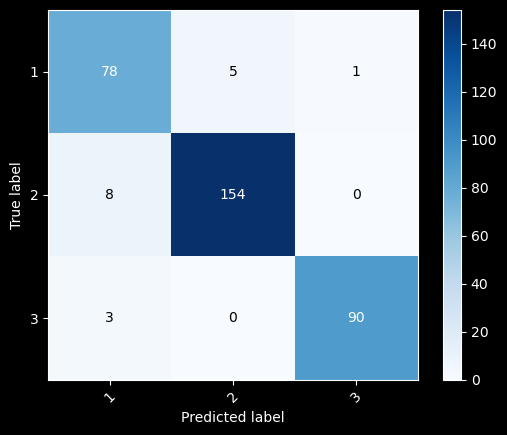

Mean test accuracy: 0.9479 +/- 0.0109
Fold 4
Found 2479 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Epoch 1/10
78/78 [==============================] - 34s 441ms/step - loss: 0.0053 - accuracy: 0.9980
Epoch 2/10
78/78 [==============================] - 34s 440ms/step - loss: 0.0020 - accuracy: 0.9992
Epoch 3/10
78/78 [==============================] - 34s 439ms/step - loss: 6.4111e-04 - accuracy: 1.0000
Epoch 4/10
78/78 [==============================] - 34s 440ms/step - loss: 0.0112 - accuracy: 0.9964
Epoch 5/10
78/78 [==============================] - 34s 439ms/step - loss: 0.0223 - accuracy: 0.9935
Epoch 6/10
78/78 [==============================] - 35s 443ms/step - loss: 0.0063 - accuracy: 0.9980
Epoch 7/10
78/78 [==============================] - 34s 440ms/step - loss: 0.0062 - accuracy: 0.9972
Epoch 8/10
78/78 [==============================] - 34s 441ms/step - loss: 0.0034 - accuracy: 0.9988
Epoch 9/10
78/78 [==============================] - 34s 437m

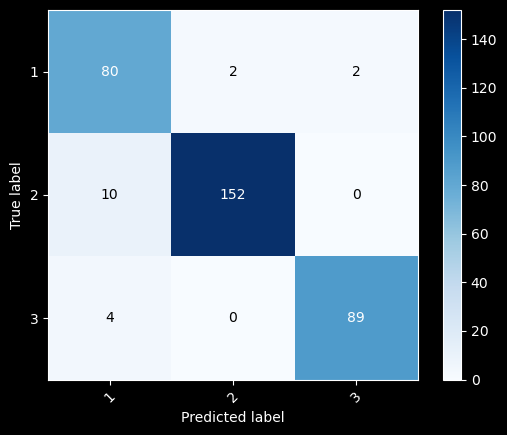

Mean test accuracy: 0.9469 +/- 0.0096
Fold 5
Found 2479 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Epoch 1/10
78/78 [==============================] - 34s 439ms/step - loss: 0.0142 - accuracy: 0.9964
Epoch 2/10
78/78 [==============================] - 34s 438ms/step - loss: 0.0301 - accuracy: 0.9927
Epoch 3/10
78/78 [==============================] - 34s 438ms/step - loss: 0.0094 - accuracy: 0.9968
Epoch 4/10
78/78 [==============================] - 35s 445ms/step - loss: 0.0049 - accuracy: 0.9988
Epoch 5/10
78/78 [==============================] - 35s 452ms/step - loss: 0.0068 - accuracy: 0.9980
Epoch 6/10
78/78 [==============================] - 35s 449ms/step - loss: 0.0076 - accuracy: 0.9980
Epoch 7/10
78/78 [==============================] - 35s 445ms/step - loss: 0.0107 - accuracy: 0.9960
Epoch 8/10
78/78 [==============================] - 34s 436ms/step - loss: 0.0061 - accuracy: 0.9984
Epoch 9/10
78/78 [==============================] - 34s 439ms/st

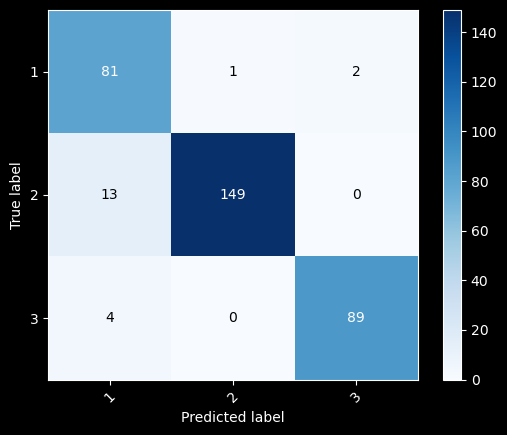

Mean test accuracy: 0.9434 +/- 0.0111


In [23]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

train_dir = 'train/'
test_dir = 'test/'

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1
)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store results
test_accuracies = []
histories = []

# Loop through each fold and train a model
for i, (train_idx, test_idx) in enumerate(kfold.split(train_generator)):
    print(f'Fold {i + 1}')
    
    # Split the data into training and test sets
    train_fold_dir = train_dir
    test_fold_dir = test_dir
    
    # Create the generators for the current fold
    train_generator_fold = datagen.flow_from_directory(
        train_fold_dir,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset='training'
    )

    test_generator_fold = datagen.flow_from_directory(
        test_fold_dir,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    )
    
    # Train the model for this fold
    history = model.fit(
        train_generator_fold,
        epochs=10,
        validation_data=None,
        callbacks=[es, mc],
    )
    
    # Evaluate the model on the test set for this fold
    test_loss, test_accuracy = model.evaluate(test_generator_fold)
    print(f'Test accuracy: {test_accuracy:.4f}')
    
    # Store the test accuracy and history for this fold
    test_accuracies.append(test_accuracy)
    histories.append(history)
    
    # Calculate and print the confusion matrix for this fold
    y_true = test_generator_fold.classes
    y_pred = np.argmax(model.predict(test_generator_fold), axis=-1)
    cm = confusion_matrix(y_true, y_pred)

    # Define class labels
    class_labels = test_generator_fold.class_indices.keys()

    # Plot the confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set tick labels and axis labels
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels, rotation=45)
    ax.set_yticklabels(class_labels)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # Add text annotations
    thresh = cm.max() / 2.0
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    plt.show()
    
    # Calculate and print the mean and standard deviation of the test accuracies
    mean_test_acc = np.mean(test_accuracies)
    std_test_acc = np.std(test_accuracies)
    print('Mean test accuracy: {:.4f} +/- {:.4f}'.format(mean_test_acc, std_test_acc))

In [24]:
# Calculate and print the mean and standard deviation of the test accuracies
mean_test_acc = np.mean(test_accuracies)
std_test_acc = np.std(test_accuracies)
print('Mean test accuracy: {:.4f} +/- {:.4f}'.format(mean_test_acc, std_test_acc))

Mean test accuracy: 0.9434 +/- 0.0111
